In [1]:
%load_ext autoreload
%autoreload 2
%cd '~/deepshape/deepshape'

/home/jorgen/deepshape/deepshape


In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import time

In [3]:
from layers import FourierLayer2D
from palais_layer import *
from surfaces import *
from visual import get_plot_data
from networks import ReparametrizationNetwork2D

In [4]:
from curves import LogStepDiff

In [5]:
figdir = "/home/jorgen/presentation/figures/cylinderwrap-nn/"

In [6]:
# TODO: Create example surfaces library, and load from there.
C = (
    lambda x: x[..., 0],
    lambda x: x[..., 1],
    lambda x: x[..., 0]**2 + x[..., 1]**2
)

C = (
    lambda x: torch.sin(2*np.pi*x[..., 0]),
    lambda x: torch.sin(4*np.pi*x[..., 0]),
    lambda x: x[..., 1]
)

f = Surface(C)
γ = Diffeomorphism(
    (
        lambda x: (0.5 * torch.log(20*x[..., 0]+1) / torch.log(21*torch.ones(1)) 
          + 0.25 * (1 + torch.tanh(20*(x[..., 0]-0.5)) / torch.tanh(21*torch.ones(1)))),
        lambda x: 0.9*x[..., 1]**2 + 0.1 * x[..., 1]))

g = f.compose(γ)
q = Qmap(g)
r = Qmap(f)

k=32
# Get color normalizer
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()
norm = colors.Normalize(vmin=min(fcolors.min(), gcolors.min()), vmax=max(fcolors.max(), gcolors.max()))

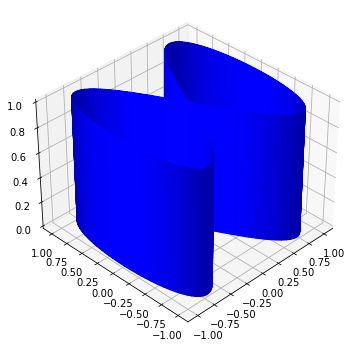

In [8]:
k = 256
Z = get_plot_data(f, k=k)
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fcolors)), rstride=2, cstride=2)
ax.view_init(35, 225)
# plt.savefig(figdir + "surface-starting.pdf")
plt.show()

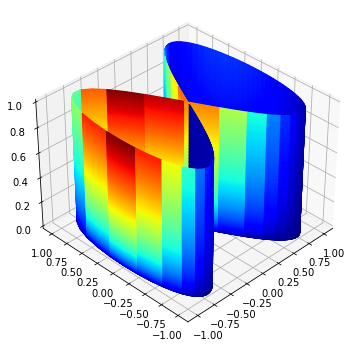

In [9]:
k = 256
Z = get_plot_data(g, k=k)
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(gcolors)), rstride=2, cstride=2)
ax.view_init(35, 225)
# plt.savefig(figdir + "surface-reparametrized.pdf")
plt.show()

In [14]:
# Instantiate a L-layer network with N basis functions per layer.
RN = ReparametrizationNetwork2D(10, 10, layer_type=PalaisLayer2D)

# opt = optim.Adam(RN.parameters(), lr=1e-3)
opt = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)
# opt = optim.RMSprop(RN.parameters(), lr=1e-4)

error = RN.train(q, r, opt, iterations=500, nxpoints=32, printiter=10, epsilon=1e-2, delta=1e-3)

[Iter     1] loss: 3.62791
[Iter    11] loss: 1.33054
[Iter    21] loss: 0.91074
[Iter    31] loss: 2.41264
[Iter    41] loss: 0.90256
[Iter    51] loss: 0.74402
[Iter    61] loss: 0.06612
[Iter    71] loss: 0.02242
[Iter    81] loss: 0.01549
[Iter    91] loss: 0.01666
[Iter   101] loss: 0.00591
[Iter   111] loss: 0.07547
[Iter   121] loss: 0.01414


KeyboardInterrupt: 

In [11]:
%matplotlib inline

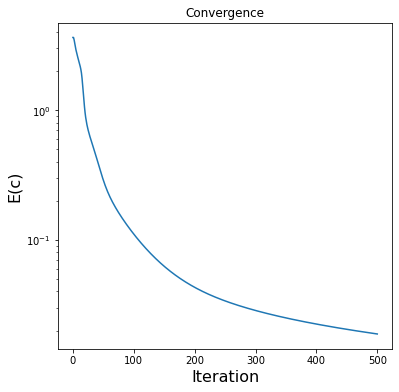

In [17]:
plt.figure(figsize=(6, 6))
plt.semilogy(error)
plt.title("Convergence")
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("E(c)", fontsize=16)

plt.savefig(figdir + "convergence.pdf")

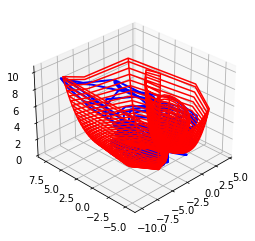

In [13]:
Zq = get_plot_data(q, k=64)
Zr = get_plot_data(r, k=64)
Zh = get_plot_data(lambda x: RN.reparametrized(r, x), k=64)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(*Zq, color='r')
ax.plot_wireframe(*Zh, color='b', lw=2.)
# ax.plot_wireframe(*Zr, color='k')

ax.view_init(30, -135)
plt.savefig("matched-qmaps.pdf")
plt.show()

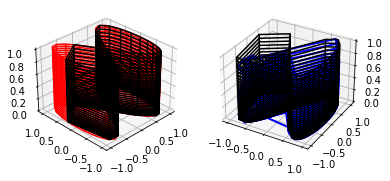

In [14]:
Zq = get_plot_data(f, k=32)
Zr = get_plot_data(g, k=32)
Zh = get_plot_data(lambda x: g(RN(x)[0]), k=32)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_wireframe(*Zq, color='r')
ax.plot_wireframe(*Zh, color='b', lw=2.)
ax1.plot_wireframe(*Zr, color='k')

ax1.view_init(30, -135)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# ax2.plot_wireframe(*Zq, color='r')
ax2.plot_wireframe(*Zh, color='b', lw=2.)
ax2.plot_wireframe(*Zr, color='k')
plt.show()

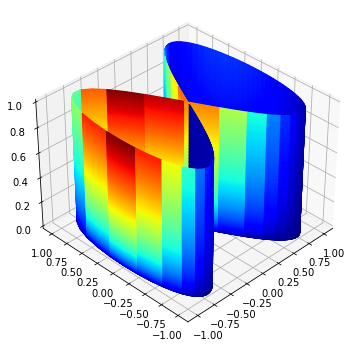

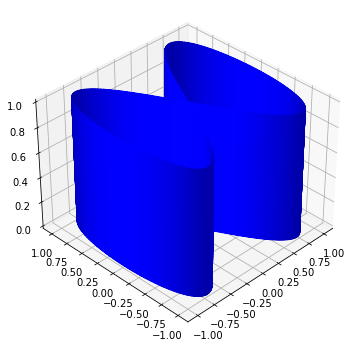

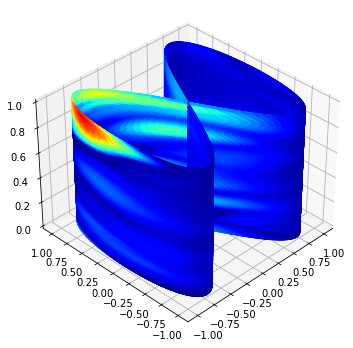

In [15]:
k = 256
Z = get_plot_data(g, k=k)
gcolors = get_plot_data(g.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(gcolors)), rstride=2, cstride=2)
ax.view_init(35, 225)
fig.savefig(figdir + "target-surface.pdf")
plt.show()

Z = get_plot_data(f, k=k)
fcolors = get_plot_data(f.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(figdir + "starting-surface.pdf")
plt.show()

fafter = f.compose(lambda x: RN(x)[0])

Z = get_plot_data(fafter, k=k)
fafcolors = get_plot_data(fafter.volume_factor, k=k).squeeze()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z, shade=False, facecolors=cm.jet(norm(fafcolors)), rstride=1, cstride=1)
ax.view_init(35, 225)
plt.savefig(figdir + "reparam-surface.pdf")
plt.show()